In [85]:
using Distributions
###########
R = 8.0; #radius of the cicle where uniform hit is generated 
#Particle 
#amorphous track parameters
E = 56.0; #C 149MeV %p 80MeV %p 18.6MeV %C 280.0Mev #He 145.74-56MeV
A = 1;
LET = 4.5; #C 149MeV 19.56 keV/um, p 80MeV 0.86(0.6) keV/um, p 18.6MeV  2.76 keV/um %C 280.0Mev 13.12 keV/um #He 145.74-56MeV 4.5
rho = 1;

par = string("He", "_", string(E));

#Time and number of particle
Dose = 12.0;
kR = 0.8;

function ATRadius(E, A, kR)

    Rc = 0.01; 

    Rp = 0.05*((E/A)^(1.7)); 

    if kR < 1.0
        Rk = Rc*exp((kR*(1+2*log(Rp/Rc))-1)/2);
    else
        Rk = Rp;
    end

    return Rc, Rp, Rk

end

(Rc, Rp, Rk) = ATRadius(E, A, kR);
println("Rc=",Rc,"\nRp=",Rp,"\nRk=",Rk)

DoseRate = 0.18; #10
DoseRate_h = DoseRate*3600;

F = Dose/(1.602*10^(-9)*LET);
Npar = round(Int, F*(pi*(R+Rk)^2*10^(-8)));
# if no simulation of time
#Np = round(Int, Dose/(1.602*10^(-9)*LET/(pi*(R+Rk)^2*10^(-8))));
#Np = Npar;

#zF = 1.602*10^(-9)*LET/(pi*(R+Rk)^2*10^(-8));
zF = Dose/Npar;
D = DoseRate_h/zF;
T = Dose/(zF*D)*3600;
#######################
function GenerateHit(R, Rk)
    
    radius = (R+Rk)*sqrt((rand(Uniform(0,1))));
    theta = 2*pi*rand(Uniform(0,1)); 
        
    x0 = radius*cos(theta);
    y0 = radius*sin(theta);
    
    return x0, y0
        
end
#######################
function GetRadialLinearDose(r)
    #LET normalized to Rk ???
    LETk = LET*0.1602;####JM: why thi is usefull?
    D_arc=0.
    if r <= Rc
        D_arc = (1/(pi*Rc^2))*(LETk/(1*(1+2*log(Rk/Rc))));
    elseif r <= Rk
        D_arc = (1/(pi*r*r))*(LETk/(1*(1+2*log(Rk/Rc))));
    end
    return D_arc
end          

Rc=0.01
Rp=46.86942766272948
Rk=7.821359928664614


GetRadialLinearDose (generic function with 1 method)

In [86]:
GenerateHit(R,Rk)

(3.2882886382811076, 14.886177761235366)

In [94]:
for r in 10^-2:10
    println(GetRadialLinearDose(r))
end

160.19874313935404
0.015704219501946292
0.003965217275298982
0.0017681785315764077
0.000996254644805406
0.0006382394617525592
0.00044351688710539037
0.0003260041048743371
0.0
0.0


In [4]:
#Compute the angle theta in rad. of the intersection arc betweentwo circles:
#lenght of the arc=theta*r, cos(Theta)=x/r=arg
#x is here:
#https://mathworld.wolfram.com/Circle-CircleIntersection.html
function arc_intersection_angle(r, b, r_nucleus)
    if b < r_nucleus
        if r <= r_nucleus - b
            return 2 * π
        elseif r < b + r_nucleus
            arg = (b*b  + r*r  - r_nucleus * r_nucleus) / (2 * b * r)
            return 2 * acos(arg)
        end
    else #(b>=r_nucleus)
        if r <= b - r_nucleus
            return 0.0 
        elseif r < b + r_nucleus
            arg =(b*b  + r*r  - r_nucleus * r_nucleus) / (2 * b * r)
            #arg = min(arg, 1.0)not sure if usefull?
            return 2 * acos(arg)
        end
    end
    return 0.0
end

arc_intersection_angle (generic function with 1 method)

In [221]:
r_nucleus=5.;
steps=100
Radius = Vector{Float64}(undef, steps)

function integrate_weighted_radial_track( rMin::Float64, rMax::Float64, b::Float64, step::Int64)
        r1, r2, log_r2, log_rMin, log_rMax, log_step = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
        f1, f2, f, arc_weight1, arc_weight2 = 0.0, 0.0, 0.0, 0.0, 0.0
        integral = 0.0

        if rMin > 0
            log_rMin = log10(rMin)
        else
            log_rMin = -5.
        end

        log_rMax = log10(rMax)
        nSteps = step
        log_step = (log_rMax - log_rMin) / nSteps
        #println(log_step) 
        if nSteps < 3
            log_step = (log_rMax - log_rMin) / 3
            nSteps = 3
        end

        area = 0.0

        arc_weight2 = arc_intersection_angle(rMin, b, r_nucleus)
        f2 = GetRadialLinearDose(rMin) * rMin * arc_weight2
        r2 = rMin

        for i in 1:nSteps - 1
            Radius[i]=r2
            log_r2 = log_rMin + log_step * (i + 1)
            f1 = f2
            r1 = r2
            arc_weight1 = arc_weight2
            #println(r2 ,"\n")
            r2 = 10^log_r2
            arc_weight2 = arc_intersection_angle(r2, b, r_nucleus)
            f2 = GetRadialLinearDose(r2) * r2 * arc_weight2
            f = (r2 - r1) * (f1 / 2.0 + f2 / 2.0)
            integral += f
            area += (r2 - r1) * (arc_weight1 * r1 / 2.0 + arc_weight2 * r2 / 2.0)
        end
        ####Pass 1<-2
        f1 = f2
        r1 = r2
        arc_weight1 = arc_weight2
        #### Fill 2
        r2 = rMax
        arc_weight2 = arc_intersection_angle(r2, b, r_nucleus)
        f2 = GetRadialLinearDose(r2) * r2 * arc_weight2
        f = (r2 - r1) * (f1 / 2.0 + f2 / 2.0)
        integral += f
        area += (r2 - r1) * (arc_weight1 * r1 / 2.0 + arc_weight2 * r2 / 2.0)

        return area, integral, area/integral
    end

integrate_weighted_radial_track (generic function with 1 method)

In [222]:
rMin=0.00001
rMax=15.
b=6.
steps=100
area,integral,Gyr=integrate_weighted_radial_track(rMin, rMax, b, steps);
println("area=",area,
    "\nPrecision=",area-25*π,"\n\nIntegral Dose=",integral,"\n\nGyr=",Gyr)

area=77.27037326560516
Precision=-1.269443074139673

Integral Dose=0.054824952179728645

Gyr=1409.4015624910228


In [223]:
Radius 

100-element Vector{Float64}:
  1.0e-5
  1.3289903429766492e-5
  1.5320845666868633e-5
  1.7662153317251884e-5
  2.0361255937504057e-5
  2.3472831194800744e-5
  2.7059912511818853e-5
  3.119516598021123e-5
  3.596236241000019e-5
  4.1458074335254425e-5
  4.779363235351671e-5
  5.5097380429961084e-5
  6.351727585360005e-5
  ⋮
  3.1384934062029473
  3.6181130553004373
  4.171027428339607
  4.80843731029202
  5.543255172554054
  6.390366750186709
  7.366932592979698
  8.492735699077192
  9.790582273429944
 11.286763729526632
 13.011589293506765
  2.697502522e-314

In [8]:
arc_intersection_weight(4,2,5)

LoadError: UndefVarError: `arc_intersection_weight` not defined

In [9]:
for b in [0,2,5,7]
    for r in [0,1,2,3,4,5,6,7,8,9,10,11,12]
        angle=arc_intersection_weight(r,b,5)
        println(b,' ',r,' ',angle)
    end
end

LoadError: UndefVarError: `arc_intersection_weight` not defined

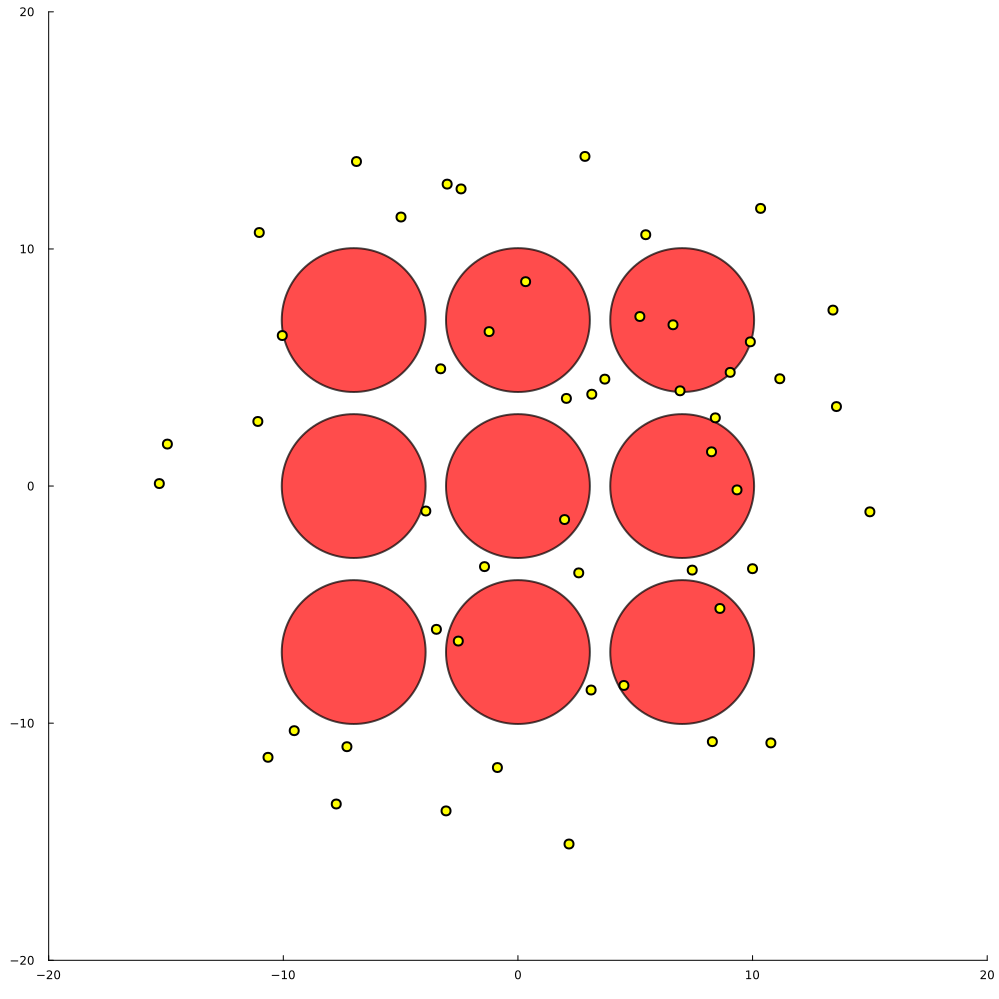

In [10]:
using Plots
using Random
#Random.seed!(2018)
x = [-7,-7,0,0,0,7,7,7,-7]
y = [-7,0,-7,0,7,0,7,-7,7]
ms = [80,80,80,80,80,80,80,80,80]
col=["red","red","red","red","red","red","red","red","red"]
scatter(x, y, markersize=ms,color=col,alpha=0.7,label="Cell")
for i in 1:50
    x,y=GenerateHit(R,Rk)
    x=[x]
    y=[y]
    ms = [5]
    col=["yellow"]
    scatter!(x, y, markersize=ms,color=col,label="track")
end
xlims!(-20,20)
ylims!(-20,20)
plot!(legend = false,grid=false,size=(1000,1000))

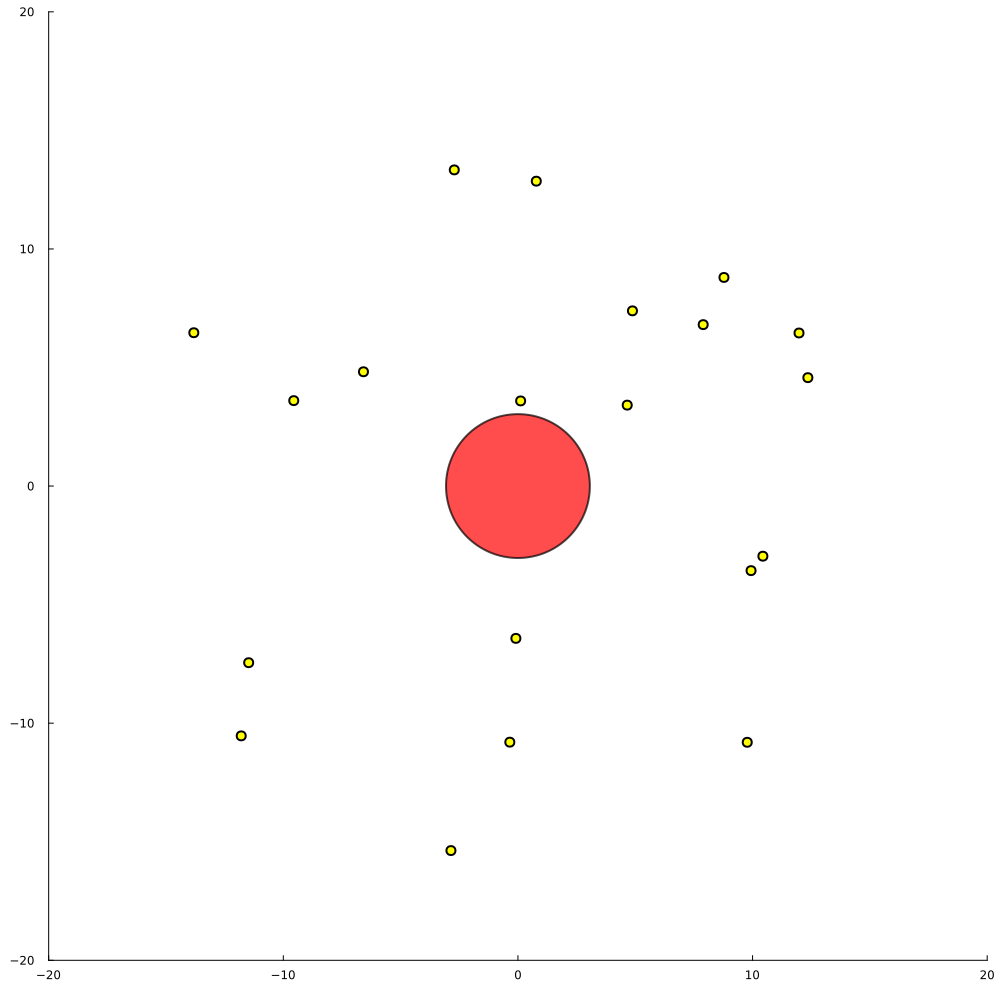

In [11]:
using Plots
using Random
#Random.seed!(2018)
x = [0]
y = [0]
ms = [80]
col=["red"]
scatter(x, y, markersize=ms,color=col,alpha=0.7,label="Cell")
for i in 1:20
    x,y=GenerateHit(R,Rk)
    x=[x]
    y=[y]
    ms = [5]
   
    scatter!(x, y, markersize=ms,color=:yellow,label="track")
end
xlims!(-20,20)
ylims!(-20,20)
plot!(legend = false,grid=false,size=(1000,1000))

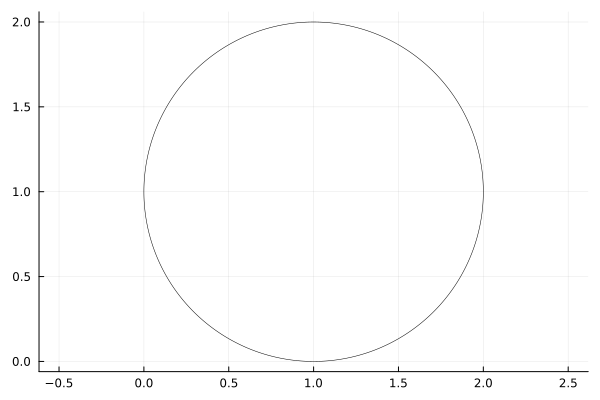

In [237]:
using Plots;
function circleShape(x,y,r)
    Theta=LinRange(0,2*π,500)
    x.+r*sin.(Theta),y.+r*cos.(Theta)
end
plot(circleShape(1,1,1),seriestype=:shape,fillalpha=0.0,lw=0.5,aspect_ratio=1,legend=false)
 


[ Info: Saved animation to /Users/jules/Desktop/SPARSITY/tmp.gif


Plots.AnimatedGif("/Users/jules/Desktop/SPARSITY/tmp.gif")
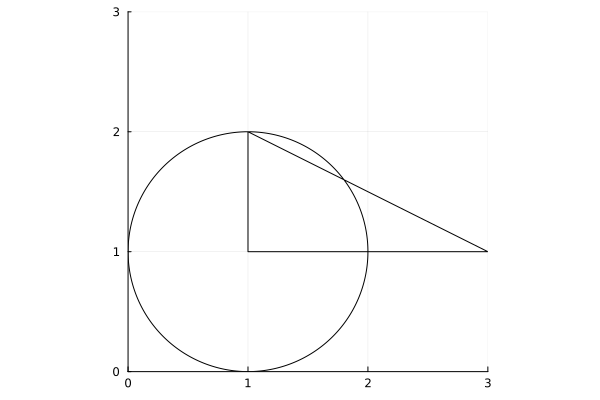

In [244]:
Base.@kwdef mutable struct Hit
    x::Float64 = 1.
    y::Float64 = 1.
    r::Float64 = 1.
end
function step!(H::Hit,r::Float64)
    H.r=r
end
H=Hit()
plt=plot(circleShape(1,1,H.r),
    seriestype=:shape,
    fillalpha=0.0,
    lw=1,
    xlim=(0,3),
    ylim=(0,3),
    legend=false,
    aspect_ratio=1)

@gif for i in length(Radius)
    step!(H,Radius[i])
    push!(plt,circleShape(1,1,H.r))
end every 10

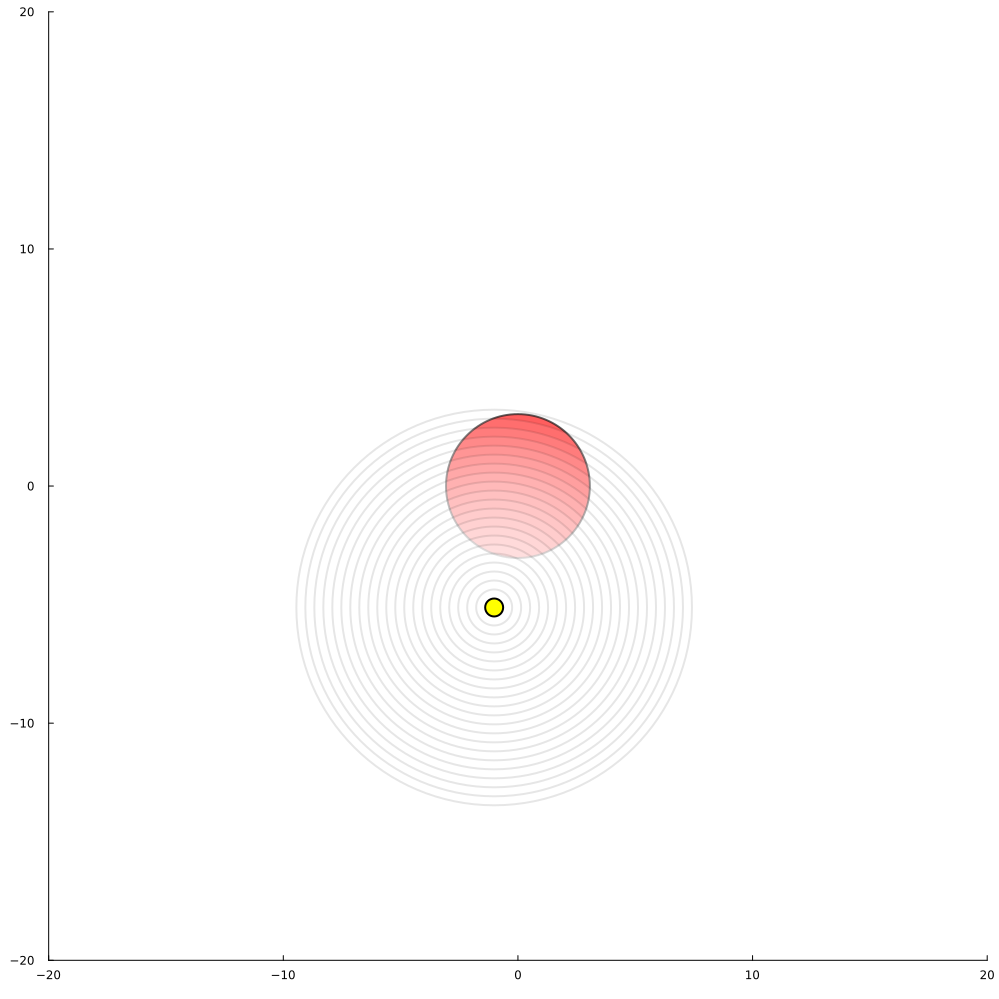

In [99]:
using Plots
using Random
Random.seed!(2024)
x = [0]
y = [0]
ms = [80]
col=["red"]
scatter(x, y, markersize=ms,color=col,alpha=0.7,label="Cell")
x,y=GenerateHit(R,Rk)
x=[x]
y=[y]
for i in 1:22

    ms = [(23-i)*10]
    if i==22
        scatter!(x, y, markersize=ms,color=:yellow,alpha=1,label="track")
    else
        scatter!(x, y, markersize=ms,color=:white,alpha=0.1,label="track")

    end
end
xlims!(-20,20)
ylims!(-20,20)
plot!(legend = false,grid=false,size=(1000,1000))

In [ ]:
function distribute_dose!(nucleus::Nucleus_Integral_t, track::Track)
        x_track, y_track = track.getPosition()
        x_track = (x_track - nucleus.x_nucleus) * 1e3  # mm -> um
        y_track = (y_track - nucleus.y_nucleus) * 1e3  # mm -> um
        b = sqrt(x_track^2 + y_track^2)

        rMax = min(track.getRadius(), b + nucleus.r_nucleus)

        area1 = area2 = area3 = 0.0

        if b <= nucleus.r_nucleus
            nucleus.inNucleusCount += 1
            rMin = 0.0

            if b + track.getRadius() < nucleus.r_nucleus
                r_intersection = track.getRadius()
            else
                r_intersection = nucleus.r_nucleus - b
            end

            area1 = π * r_intersection^2
            dose = track.getRadialIntegral(0.0, r_intersection) * area1

            if rMax > r_intersection
                area2 = integrate_weighted_radial_track(track, r_intersection, rMax, b, 0.01)
                dose += area2
            end

            if rMax == track.getRadius()
                if track.getRadius() > nucleus.r_nucleus - b
                    theta1 = acos((b^2 + track.getRadius()^2 - nucleus.r_nucleus^2) / (2 * b * track.getRadius()))
                    theta2 = acos((b^2 - track.getRadius()^2 + nucleus.r_nucleus^2) / (2 * b * nucleus.r_nucleus))
                    area3 = π * nucleus.r_nucleus^2 - (theta1 * track.getRadius()^2 + theta2 * nucleus.r_nucleus^2 - track.getRadius() * b * sin(theta1))
                else
                    area3 = π * (nucleus.r_nucleus^2 - r_intersection^2)
                end
            end

            dose /= area1 + area2 + area3

            nucleus.totalNucleusDose += dose
            push!(nucleus.doses, dose)
            push!(nucleus.times, track.getTime())
        elseif b <= nucleus.r_nucleus + track.getRadius()
            nucleus.intersectionCount += 1
            rMin = b - nucleus.r_nucleus
            area2 = integrate_weighted_radial_track(track, rMin, rMax, b, 0.01)
            dose = area2

            if rMax == track.getRadius()
                theta1 = acos((b^2 + track.getRadius()^2 - nucleus.r_nucleus^2) / (2 * b * track.getRadius()))
                theta2 = acos((b^2 - track.getRadius()^2 + nucleus.r_nucleus^2) / (2 * b * nucleus.r_nucleus))
                area3 = π * nucleus.r_nucleus^2 - (theta1 * track.getRadius()^2 + theta2 * nucleus.r_nucleus^2 - track.getRadius() * b * sin(theta1))
            end

            dose /= area2 + area3

            nucleus.totalNucleusDose += dose
        return dose
            push!(nucleus.doses, dose)
            push!(nucleus.times, track.getTime())
        end
    end
